# 模型构筑：从0实现用户氪金行为预测

## 1 导库，整合数据

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
%matplotlib inline
plt.rcParams['font.sans-serif']=['Simhei']
plt.rcParams['axes.unicode_minus']=False

In [2]:
#更改列名为中文
data = pd.read_csv(r".\数据\tap4fun竞赛数据\tap_fun_train.csv")
column_name = pd.read_excel(r".\数据\tap4fun竞赛数据\tap4fun 数据字段解释.xlsx")
data.columns = column_name["字段解释"]

In [3]:
data.head()

字段解释,玩家唯一ID,玩家注册时间,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,45日付费金额
0,1,2018-02-02 19:47:15,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
1,1593,2018-01-26 00:01:05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.333333,0.0,0,0.0
2,1594,2018-01-26 00:01:58,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,1.166667,0.0,0,0.0
3,1595,2018-01-26 00:02:13,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,3.166667,0.0,0,0.0
4,1596,2018-01-26 00:02:46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,2.333333,0.0,0,0.0


## 2. 数据预处理：注册时间与氪金状况有关吗？

从游戏世界的常识以及之前的分析结果来看，资源量的累计、在线时长等特征与用户体验的深度有较大的关联，也就与是否氪金、氪多少金额有较大的关联。但在我们的特征矩阵中，还有一类尚未分析的特征，玩家注册时间，这是全数据集中唯一一个object类型的对象。

In [4]:
data.loc[:,"玩家注册时间"]

0          2018-02-02 19:47:15
1          2018-01-26 00:01:05
2          2018-01-26 00:01:58
3          2018-01-26 00:02:13
4          2018-01-26 00:02:46
                  ...         
2288002    2018-02-03 14:54:10
2288003    2018-02-03 14:55:21
2288004    2018-02-03 14:56:35
2288005    2018-02-03 14:57:51
2288006    2018-02-03 14:58:45
Name: 玩家注册时间, Length: 2288007, dtype: object

从常识来看，一般注册时间与用户的氪金行为应该关系不大，在这里我们将时间分成日期和时刻来考虑，分别绘制横坐标为注册日期/注册时刻、纵坐标为该日期/该时刻注册用户氪金均值的关系图，以此来观察注册日期、时刻与氪金是否有关。

In [5]:
import time
import datetime

In [6]:
# 首先将玩家注册日期提取出来作为新的一列
RegisterDate = data.loc[:,"玩家注册时间"].apply(lambda x: x[:10])
RegisterDate

0          2018-02-02
1          2018-01-26
2          2018-01-26
3          2018-01-26
4          2018-01-26
              ...    
2288002    2018-02-03
2288003    2018-02-03
2288004    2018-02-03
2288005    2018-02-03
2288006    2018-02-03
Name: 玩家注册时间, Length: 2288007, dtype: object

In [7]:
#按照玩家注册日期对付费金额进行聚合平均计算
RegisterDateMean = data["付费金额"].groupby(RegisterDate).mean()
RegisterDateMean

玩家注册时间
2018-01-26    0.828631
2018-01-27    0.411715
2018-01-28    0.424587
2018-01-29    0.565344
2018-01-30    0.776891
2018-01-31    0.353800
2018-02-01    0.304698
2018-02-02    0.846928
2018-02-03    0.741158
2018-02-04    0.440295
2018-02-05    0.684033
2018-02-06    0.413324
2018-02-07    0.454560
2018-02-08    0.478379
2018-02-09    0.653726
2018-02-10    0.682243
2018-02-11    0.405305
2018-02-12    0.820042
2018-02-13    0.459915
2018-02-14    0.484836
2018-02-15    0.252700
2018-02-16    0.811025
2018-02-17    0.399717
2018-02-18    0.396659
2018-02-19    0.370515
2018-02-20    0.271209
2018-02-21    0.435525
2018-02-22    0.477723
2018-02-23    1.041871
2018-02-24    0.702184
2018-02-25    0.515020
2018-02-26    0.956741
2018-02-27    0.413218
2018-02-28    0.527081
2018-03-01    0.503308
2018-03-02    0.702079
2018-03-03    0.389855
2018-03-04    0.381600
2018-03-05    0.695222
2018-03-06    0.807820
Name: 付费金额, dtype: float64

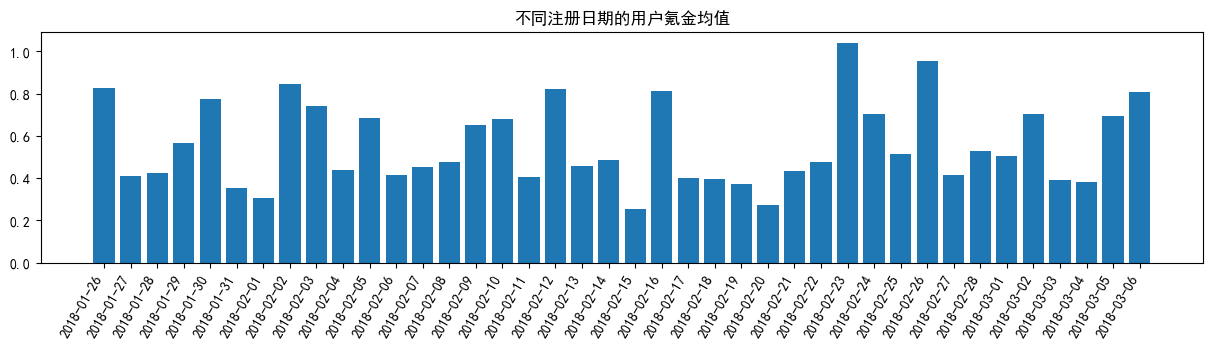

In [8]:
#绘制图像
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册日期的用户氪金均值")
plt.bar(RegisterDateMean.index, RegisterDateMean.values)
plt.xticks(RegisterDateMean.index,rotation=60,ha="right");

从图上来看，几乎无法看出日期与氪金数额有所联系。看起来整体是比较随机而且杂乱的，但是每隔几天就会有一个高峰。我们可以试试看将日期转化为一星期中的七天，观察一下星期和氪金数额是否有明显的关系。

In [9]:
#必须要将字符串转化为python可以读取的时间格式，这样python才能够基于日期帮助我辨别，这个日期是星期几
#weekday - [0,1,2,3,4,5,6]
datetime.datetime.strptime(data.loc[0,"玩家注册时间"][:10],"%Y-%m-%d").weekday()

4

In [10]:
RegisterWeekday = data.loc[:,"玩家注册时间"].apply(lambda x: datetime.datetime.strptime(x[:10],"%Y-%m-%d").weekday()+1) #1~7分别代表周一到周日

In [11]:
RegisterWeekday

0          5
1          5
2          5
3          5
4          5
          ..
2288002    6
2288003    6
2288004    6
2288005    6
2288006    6
Name: 玩家注册时间, Length: 2288007, dtype: int64

In [12]:
RegisterWeekDayMean = data["付费金额"].groupby(RegisterWeekday).mean()

RegisterWeekDayMean

玩家注册时间
1    0.618232
2    0.484993
3    0.447997
4    0.378135
5    0.814581
6    0.548842
7    0.426176
Name: 付费金额, dtype: float64

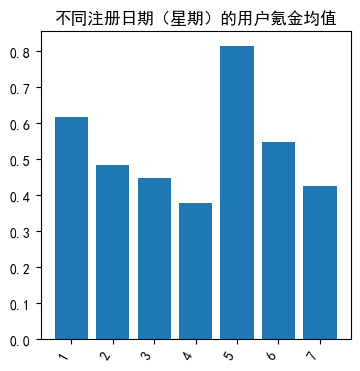

In [13]:
#绘制图像
plt.figure(figsize=(4,4),dpi=100)
plt.title("不同注册日期（星期）的用户氪金均值")
plt.bar(RegisterWeekDayMean.index, RegisterWeekDayMean.values)
plt.xticks(RegisterWeekDayMean.index,rotation=60,ha="right");

很明显，周五、周一注册的人有较高的氪金金额，并且在高峰之后会逐渐下降。这个趋势看起来是氪金金额与星期相关，但实际上更可能是跟游戏买量、投放的节奏和渠道有关。或许每周五、每周一都可以排到质量较高的用户所在的渠道，或者周五会吸引到大量准备过周末的玩家的注意、周一则会吸引到大量还不想投入工作的玩家的注意。周五与周一的高峰暗示这两天进入的流量可能是有规律工作、有经济收入的人。但无论真相是什么，从特征的角度来看，我们可以计算一下星期与45日付费金额的相关系数：

In [14]:
pd.concat([data["45日付费金额"],RegisterWeekday],axis=1).corr()

,45日付费金额,玩家注册时间
45日付费金额,1.00000,0.00017
玩家注册时间,0.00017,1.00000


相关系数非常非常小，两者几乎不相关，我们可以不将**星期**放入特征矩阵了。

判断**时刻**是否有影响

In [15]:
#将时刻也单独列一列，提取小时数作为特征
RegisterTime = data.loc[:,"玩家注册时间"].apply(lambda x: int(x[11:13]))
RegisterTime

0          19
1           0
2           0
3           0
4           0
           ..
2288002    14
2288003    14
2288004    14
2288005    14
2288006    14
Name: 玩家注册时间, Length: 2288007, dtype: int64

In [16]:
#按玩家注册时刻进行聚合，求均值
RegisterTimeMean = data["付费金额"].groupby(RegisterTime).mean()
RegisterTimeMean

玩家注册时间
0     0.542833
1     0.432465
2     0.350108
3     0.400207
4     0.390398
5     0.426960
6     0.427454
7     0.363325
8     0.370818
9     0.334605
10    1.268075
11    1.027658
12    0.726206
13    0.520226
14    0.570217
15    0.640136
16    0.725031
17    0.449590
18    0.464896
19    0.382819
20    0.388107
21    0.432118
22    0.598543
23    0.570575
Name: 付费金额, dtype: float64

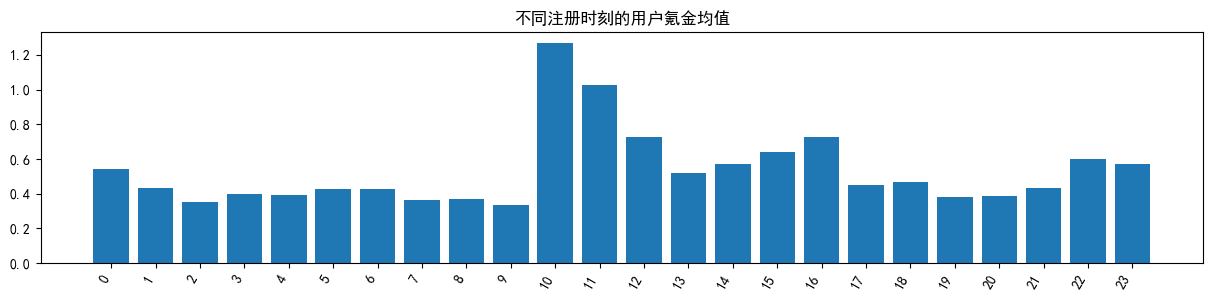

In [17]:
#绘制图像
plt.figure(figsize=(15,3),dpi=100)
plt.title("不同注册时刻的用户氪金均值")
plt.bar(RegisterTimeMean.index, RegisterTimeMean.values)
plt.xticks(RegisterTimeMean.index,rotation=60,ha="right");

早上10点-12点之间注册的用户、以及下午4点-5点之间表现出比其他时段注册的用户更高的氪金能力，这可能是与推广渠道有关，也可能真的是注册时刻与氪金金额有关。巧合的是，上午10点与下午4点正是上班时间中摸鱼喝茶的时间，如果能够确定这个时间在推广的是哪些渠道，就能够确定相关用户的画像，来判断是否真是时间与氪金数额有关了。同时，也来看看相关系数：

In [18]:
pd.concat([data["45日付费金额"],RegisterTime],axis=1).corr()

,45日付费金额,玩家注册时间
45日付费金额,1.000000,0.000708
玩家注册时间,0.000708,1.000000


看起来注册时刻与付费金额有一点点关系（非常微弱），我们可以保留注册时刻为建模用。

增加玩家注册时刻作为特征，注意要添加到标签的前面，维持标签是最后一列

In [19]:
data.shape[1]

109

In [20]:
data.insert(data.shape[1]-1,"玩家注册时刻",RegisterTime)

现在我们可以删除最初的“注册时间”这个特征了，同时，我们也可以将玩家唯一ID删除，因为ID应当不是有助于建模的特征。

In [21]:
data.drop(columns=["玩家注册时间","玩家唯一ID"],inplace=True) #删除不需要的特征

In [22]:
data.columns

Index(['木头获取数量', '木头消耗数量', '石头获取数量', '石头消耗数量', '象牙获取数量', '象牙消耗数量', '肉获取数量',
       '肉消耗数量', '魔法获取数量', '魔法消耗数量',
       ...
       '主动发起PVP次数', 'PVP胜利次数', 'PVE次数', '主动发起PVE次数', 'PVE胜利次数', '在线时长', '付费金额',
       '付费次数', '玩家注册时刻', '45日付费金额'],
      dtype='object', name='字段解释', length=108)

## 3. 模型选择与benchmark

在2018年DC竞赛上，《野蛮时代》数据集上拿到冠军的团队实现了RMSE=40，前10名的RMSE值为55.444，前20名的RMSE值为57.67，我们可以以50为目标来进行调整。在建模之前，我们需要构建自己的benchmark，来对比我们的优化流程是否有效。<br>
竞赛benchmark走这里：https://js.dclab.run/v2/cmptDetail.html?id=226

In [23]:
data.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻,45日付费金额
0,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,0.0,0.0,...,0,0,0,0,0,0.333333,0.0,0,19,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0.333333,0.0,0,0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,1.166667,0.0,0,0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,3.166667,0.0,0,0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,2.333333,0.0,0,0,0.0


In [24]:
# 将标签提取出来，分割标签与特征
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [25]:
X.shape, y.shape

((2288007, 107), (2288007,))

In [26]:
y.head()

0    0.0
1    0.0
2    0.0
3    0.0
4    0.0
Name: 45日付费金额, dtype: float64

在现有数据量的要求下，我们首先要考虑计算迅速且简单的线性模型：线性回归。

经测试，200w数据集在100棵树的随机森林上跑一次大约需要半小时时间，在100棵树的XGBoost上跑一次大约需要40分钟时间，大家可以根据自己的需求更换为**树模型**，但课程中建议使用速度较快的**线性模型**，方便跑模型和讲解优化过程。

**建立benchmark**

In [27]:
from sklearn.linear_model import LinearRegression as LR #线性回归
from sklearn.model_selection import train_test_split as TTS #分割训练集与测试集的类
from sklearn.metrics import mean_squared_error as MSE #模型评估指标

In [28]:
#数据分割
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.3,random_state=1412)

In [29]:
Xtrain.shape

(1601604, 107)

In [30]:
Xtest.shape

(686403, 107)

In [31]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,PVP次数,主动发起PVP次数,PVP胜利次数,PVE次数,主动发起PVE次数,PVE胜利次数,在线时长,付费金额,付费次数,玩家注册时刻
243592,10000.0,600.0,0.0,0.0,0.0,0.0,10000.0,400.0,0.0,0.0,...,0,0,0,0,0,0,0.166667,0.0,0,19
361662,39038.0,8750.0,0.0,0.0,3000.0,0.0,42434.0,6060.0,0.0,0.0,...,1,0,0,1,1,1,0.833333,0.0,0,12
1319519,10000.0,1600.0,0.0,0.0,0.0,0.0,10000.0,900.0,0.0,0.0,...,0,0,0,0,0,0,0.166667,0.0,0,15
276423,26625.0,6900.0,0.0,0.0,0.0,0.0,31625.0,3900.0,0.0,0.0,...,1,1,0,0,0,0,4.500000,0.0,0,9
1060863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0.666667,0.0,0,4


In [32]:
# 建模
reg = LR() # 实例化

In [33]:
reg_benchmark = reg.fit(Xtrain,Ytrain) # 训练

In [34]:
reg_benchmark.score(Xtrain,Ytrain) # 训练集上的分数

0.5604160157526336

In [35]:
reg_benchmark.score(Xtest,Ytest) # 测试集上的分数

0.5581998030190547

In [36]:
# 模型处于欠拟合状态——在训练集和测试集上的分数都不是很高，并且两者分数相似
# 简单的线性模型在学习能力上略显不足

In [37]:
y_pred = reg_benchmark.predict(Xtest) # 测试集上的预测标签

In [38]:
# 根均方误差RMSE
np.sqrt(MSE(Ytest,y_pred)) 

62.00116183660688

benchmark：
62的RMSE，以及55.8%的r^2

之后应该提升R^2，降低RMSE

试着使用其他模型进行预测。现在的数据量对于树的集成模型来说过于巨大，因此我们只能够在有限的条件下进行尝试：

In [39]:
from sklearn.ensemble import RandomForestRegressor as RFR

In [40]:
#给出非常少的树的数量，以及限制每次分枝所使用的最大特征量
reg_tree = RFR(n_estimators=10,max_features=5) #100+，max_features=5

In [41]:
##=====【TIME WARNING：2mins】======##
reg_tree.fit(Xtrain,Ytrain)

RandomForestRegressor(max_features=5, n_estimators=10)

In [42]:
reg_tree.score(Xtrain,Ytrain) # 训练集上的R^2

0.8812520946581133

In [43]:
reg_tree.score(Xtest,Ytest) # 测试集上的R^2

0.4105992243236156

In [44]:
# 随即森林处于过拟合的状态
# 有机会应该对RF进行抗过拟合的调参，来试着使用树模型

In [45]:
y_pred = reg_tree.predict(Xtest)

In [46]:
np.sqrt(MSE(Ytest,y_pred))

71.61305923747159

这不是一个很好的征兆。通常来说，如果一个数据在线性模型上表现较好，在树模型上表现较差，则说明该数据的分布规律接近线性规律，更适用于线性回归、贝叶斯这些模型。反之，则说明该数据的分布更接近非线性规律，更适合树模型这样的非线性模型。但如果树模型和线性模型表现出差不多的结果、并且两种结果都不高，则说明数据本身的学习难度较大。我们可以尝试着对随机森林稍微进行调整，会发现无论我们对模型做什么，模型的RMSE都非常高。

In [47]:
##=====【TIME WARNING：10mins】======##
reg_tree2 = RFR(n_estimators=20,max_features=5).fit(Xtrain,Ytrain) #增大树的数量

In [48]:
np.sqrt(MSE(Ytest,reg_tree2.predict(Xtest)))

66.80900039883208

In [49]:
reg_tree3 = RFR(n_estimators=20,max_depth=2,max_features=5).fit(Xtrain,Ytrain) #控制最大深度

In [50]:
np.sqrt(MSE(Ytest,reg_tree3.predict(Xtest)))

71.03528601491129

**如果建立benchmark的时候发现最佳模型就是线性回归，那基本没有任何可以调整的余地了，因为线性回归几乎没有任何可以调整的参数。** 根据经验，面对这样的数据，要么花大量精力做特征工程，要么使用神经网络进行建模。但无论如何，我们先尽一切努力降低数据集上的RMSE。

## 4. 特征工程(1)：根据业务模式新增特征

在之前众多业务模式分析当中，我们已经对SLG游戏的业务以及游戏本身有了很多的了解。现在我们可以基于这些了解来构筑新的特征。在对算法进行建模时，我们经常使用以下方式对现有特征进行重组，来生成新特征：

- 1. 特征之间**加减乘除**
- 2. 对特征进行简单**数学运算**（绝对值，取对数）
- 3. 对特征进行**逻辑运算**（and, or, 并集，交集，最大值，最小值）
- 4. 对特征进行**聚合运算**（按照离散特征聚合后取中位数、均值、众数、标准差、方差、频数）
- 5. 对特征使用**多项式**拓展方法（即特征与自身、与其他特征相乘）
- 6. 对连续特征进行**分箱**
- 7. 对离散特征进行**独热编码**

基于我们对业务的理解，事实上现在的数据集中有非常多可以增加的特征，例如：

> - 个人PVP胜率 = PVP胜利次数/PVP次数，无PVP的用户胜率为0
> - 主动发起PVP的概率 = 主动发起PVP次数/PVP次数，无PVP的用户主动发起为0
> - 玩家发育效率 = 平均资源获取数/在线时长 （该指标高的人擅长游戏）
> - 玩家升级效率 = 技能的平均等级/在线时长
> - 氪金发育效率 = 平均资源获取数/7日付费金额 （该指标高的人善用氪金资源）
> - 氪金升级效率 = 技能的平均等级/7日付费金额

还可以对7日付费金额、在线时长等明显对氪金有影响的特征分箱，并按分箱后的类别求资源、PVP胜率等与游戏体验深度相关的特征的聚合函数，这一点对于树模型会尤其有效。在有限的时间内，我们无法对所有可能增加的特征都进行计算，因此我们选择手动增加以上6个特征，作为一种尝试：

In [51]:
X.columns.tolist() #能够从我自己的特征矩阵里分别出，哪些是技能，哪些是资源

['木头获取数量',
 '木头消耗数量',
 '石头获取数量',
 '石头消耗数量',
 '象牙获取数量',
 '象牙消耗数量',
 '肉获取数量',
 '肉消耗数量',
 '魔法获取数量',
 '魔法消耗数量',
 '勇士招募数量',
 '勇士损失数量',
 '驯兽师招募数量',
 '驯兽师损失数量',
 '萨满招募数量',
 '萨满损失数量',
 '勇士伤兵产生数量',
 '勇士伤兵恢复数量',
 '驯兽师伤兵产生数量',
 '驯兽师伤兵恢复数量',
 '萨满伤兵产生数量',
 '萨满伤兵恢复数量',
 '通用加速获取数量',
 '通用加速使用数量',
 '建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '训练加速获取数量',
 '训练加速使用数量',
 '治疗加速获取数量',
 '治疗加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',
 '科研：象牙采集',
 '科研：肉类采集'

In [52]:
GrowthFeature = [] #发育 - 关于资源的部分
LevelUpFeature = [] #等级 - 关于技能的部分

for i in X.columns:
    if "招募" in i or "获取" in i:
        GrowthFeature.append(i)
    if "建筑" in i or "科研" in i:
        LevelUpFeature.append(i)

In [53]:
GrowthFeature

['木头获取数量',
 '石头获取数量',
 '象牙获取数量',
 '肉获取数量',
 '魔法获取数量',
 '勇士招募数量',
 '驯兽师招募数量',
 '萨满招募数量',
 '通用加速获取数量',
 '建筑加速获取数量',
 '科研加速获取数量',
 '训练加速获取数量',
 '治疗加速获取数量']

In [54]:
LevelUpFeature

['建筑加速获取数量',
 '建筑加速使用数量',
 '科研加速获取数量',
 '科研加速使用数量',
 '建筑：士兵小屋等级',
 '建筑：治疗小井等级',
 '建筑：要塞等级',
 '建筑：据点传送门等级',
 '建筑：兵营等级',
 '建筑：治疗之泉等级',
 '建筑：智慧神庙等级',
 '建筑：联盟大厅等级',
 '建筑：仓库等级',
 '建筑：瞭望塔等级',
 '建筑：魔法幸运树等级',
 '建筑：战争大厅等级',
 '建筑：联盟货车等级',
 '建筑：占卜台等级',
 '建筑：祭坛等级',
 '建筑：冒险传送门等级',
 '科研：侦查等级',
 '科研：训练速度等级',
 '科研：守护者',
 '科研：巨兽驯兽师',
 '科研：吟唱者',
 '科研：勇士攻击',
 '科研：驯兽师攻击',
 '科研：萨满攻击',
 '科研：战斗大师',
 '科研：高阶巨兽骑兵',
 '科研：图腾大师',
 '科研：部队防御',
 '科研：勇士防御',
 '科研：驯兽师防御',
 '科研：萨满防御',
 '科研：勇士生命',
 '科研：驯兽师生命',
 '科研：萨满生命',
 '科研：狂战士',
 '科研：龙骑兵',
 '科研：神谕者',
 '科研：部队攻击',
 '科研：建造速度',
 '科研：资源保护',
 '科研：部队消耗',
 '科研：木材生产',
 '科研：石头生产',
 '科研：象牙生产',
 '科研：肉类生产',
 '科研：木材采集',
 '科研：石头采集',
 '科研：象牙采集',
 '科研：肉类采集',
 '科研：部队负重',
 '科研：魔法采集',
 '科研：魔法生产',
 '科研：据点耐久',
 '科研：据点二',
 '科研：医院容量',
 '科研：领土采集奖励',
 '科研：治疗速度',
 '科研：据点三',
 '科研：联盟行军速度',
 '科研：战斗行军速度',
 '科研：采集行军速度',
 '科研：据点四',
 '科研：增援部队容量',
 '科研：行军大小',
 '科研：资源帮助容量']

In [55]:
X["PVP胜率"] = X["PVP胜利次数"]/X["PVP次数"]
X["主动发起PVP的概率"] = X["主动发起PVP次数"]/X["PVP次数"]
X["玩家发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["在线时长"]
X["氪金发育效率"] = X.loc[:,GrowthFeature].mean(axis=1)/X["付费金额"]
X["玩家升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["在线时长"]
X["氪金升级效率"] = X.loc[:,LevelUpFeature].mean(axis=1)/X["付费金额"]

In [56]:
#使用除法时千万记得查看除0错误与极值错误(分子特别大或者分母特别小)
#有许多PVP次数为0的用户，他们的胜率也算是0，但在进行除法计算时，会形成空值
#以及，当分子过大、分母过小时，会形成inf，这类用户则需要判断，究竟是分子过大还是分母过小

X["PVP胜率"].isnull().sum()

1712305

In [57]:
X["氪金发育效率"].describe()

D:\ProgramFiles\anaconda3\Lib\site-packages\numpy\lib\function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


count    1665563.0
mean           inf
std            NaN
min            0.0
25%            NaN
50%            NaN
75%            NaN
max            inf
Name: 氪金发育效率, dtype: float64

极限值为什么出现？虽然有些分子的确比较大，但是大部分分母其实都是个位数或者很小<br>
氪金发育效率出现问题的根本还是因为许多氪金数额过小（分母过小），而不是因为分子过高<br>
因此对于出现inf问题的样本，使用0覆盖

In [58]:
#处理除0错误，处理极值错误
for newfeature in ["PVP胜率","主动发起PVP的概率","玩家发育效率","玩家升级效率","氪金发育效率","氪金升级效率"]:
    X.loc[X[newfeature].isnull(),newfeature] = 0 #将所有的空值，变为0
    X.loc[X[newfeature] == float("inf"), newfeature] = 0 #分母很小的这样的情况

In [59]:
X["玩家发育效率"].isnull().sum()

0

In [60]:
(X["氪金发育效率"] == float("inf")).sum()

0

**强烈推荐尝试分箱+聚合的组合。**

除此之外，我们在之前分析游戏的经营状况时，已经得出了一些关于用户价值的关键结论：
> - 分析营收状况时，我们发现如果用户**7日内付费超过6元**，则他/她在7日后继续付费的概率大于不再付费的概率，是高价值用户<br><br>
> - 分析用户在线时间时，当用户的**在线时间小于15（20）或者大于800（900）分钟**，用户对氪金金额的贡献率较小，是低价值用户<br><br>
> - 分析游戏竞争状况与游戏平衡性时，我们发现，**主动发起PVP概率大于50%**的用户贡献了较多氪金金额，是高价值用户<br><br>
> - 在分析资源获取难度、新手友好程度时，我们发现**初始资源（木头）获取数量为0或很低**的玩家是低价值用户<br><br>
> - 在分析异常值时，我们发现异常用户覆盖了全部氪金用户，因为氪金用户的资源量往往都很大。然而不氪金的用户也有许多拥有大量资源，他们是肝帝，肝到一定程度就不会氪金，因此**资源量巨大（异常）但7日内没有付费**的用户是低价值用户

基于这些发现，我们统一让低价值用户被标记为0，高价值用户被标记为1，为特征矩阵创造如下新特征：

- **高价值玩家**
> - 潜力玩家：7日内付费超过6元
> - 好战玩家：主动发起PVP概率大于50%

- **低价值玩家**
> - 佛系玩家：主动发起PVP概率小于20%，或一次也没有参与过PVP
> - 肝帝玩家：7日在线时间过长，或资源量巨大但7日内没有付费
> - 菜鸡玩家：参与过PVP且个人PVP胜率小于10%
> - 流失玩家：7日在线时间过短，或初始资源获取数量小于10000

事实上还有相当多类似的特征我们可以细致地划分，这可能涉及到用户在游戏中的行为画像。例如，PVP胜率很高的“大神玩家”，PVP次数很多但是胜率很低的“又菜又勇”玩家，从来不玩PVP但是PVE胜率很高、资源量高到飞起的“圈地自萌”玩家，这些复杂的情况可能都与最终的氪金行为有关。现在让我们根据这些发现，来进行特征衍生：

In [61]:
#高价值玩家，符合条件的被标注为1
X["潜力玩家"] = (X["付费金额"] >= 5.98).astype(int)
X["好战玩家"] = (X["主动发起PVP的概率"] >= 0.5).astype(int)

#低价值玩家，符合条件的被标注为0
X["肝帝玩家"] = (X["在线时长"] > 800).apply(lambda x: not x).astype(int)
X["佛系玩家"] = ((X["主动发起PVP的概率"] < 0.2) | (X["PVP次数"] == 0)).apply(lambda x: not x).astype(int)
X["菜鸡玩家"] = ((X["PVP胜率"]< 0.1) & (X["PVP次数"] != 0)).apply(lambda x: not x).astype(int)
X["流失玩家"] = ((X["在线时长"] <= 15) | (X["木头获取数量"] <= 10000)).apply(lambda x: not x).astype(int)

In [62]:
X.isnull().sum().sum()

0

In [63]:
X.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
0,20125.0,3700.0,0.0,0.0,0.0,0.0,16375.0,2000.0,0.0,0.0,...,8446.162292,0.0,2.260872,0.0,0,0,1,0,1,0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0


## 5. 特征工程(2)：达成建模所需的统计假设

为了数据能够有效在线性回归中运行，我们希望能够避免异常值、偏左分布等因子带来的影响。因此，我们希望对训练集做出以下预处理：
> 1. **相关性分析**：我们可以删除与标签相关性不足或为0的特征，并观察哪些特征与标签有关联
> 2. **训练/测试比例调优**：调整训练集测试集比例，找出最佳的test_size超参数
> 3. **异常值处理**：按照箱线图的规则，对异常值中7日内无氪金的玩家进行中位数覆盖处理，对于7日内有氪金的玩家不处理
> 4. **数据归一化**：为排除量纲不统一问题带来的困扰，同时在大数据量情况下加速计算速度，我们需将所有特征属性归一化到[0,1]范围内
> 5. **数据正态化**(可选)：从统计学角度来看，正态化的特征数据更有可能拟合出优秀的结果，我们可以试试box-cox正态化后数据的结果

#### 5.1 相关性分析：筛选特征/特征重要性

现在模型有100+多个特征，为了能够增加计算速度/降低计算成本/做类似于多项式的特征衍生方法，我们可以简单使用相关系数对特征进行筛选。最简单的方式就是使用皮尔逊相关系数。

DataFrame可以直接用函数.corr()来计算相关系数，但由于我们有100多个特征，每条特征220w样本，直接使用corr()函数对所有特征进行计算不仅非常占用计算内存，并且计算会非常缓慢，因此在这里我们简化一下——只考虑特征与标签之间的相关性，不考虑特征与特征之间的相关性带来的统计学方面的问题。

在传统统计学中，如果特征与特征之间的线性相关性过高，线性回归是不能够处理的，不过现在sklearn库中的线性回归是使用SVD分解方式在进行计算，可以克服传统线性回归无法处理高线性相关特征的问题，因此我们可以忽略这个问题。

In [64]:
corr_list = pd.DataFrame() #空的DataFrame

In [65]:
for idx, column in enumerate(X.columns):
    corr_ = pd.concat([y,X.loc[:,column]],axis=1).corr().iloc[0,1] #每一列我计算这一列与标签的相关系数
    corr_list.loc[idx,"特征"] = column
    corr_list.loc[idx,"相关系数"] = corr_

In [66]:
corr_list.head()

,特征,相关系数
0,木头获取数量,0.639830
1,木头消耗数量,0.619171
2,石头获取数量,0.648326
3,石头消耗数量,0.631446
4,象牙获取数量,0.658366


In [67]:
corr_list.sort_values("相关系数",ascending=False).head(10) #越深入参与游戏，氪金的可能性应该就越高

,特征,相关系数
104,付费金额,0.735235
4,象牙获取数量,0.658366
2,石头获取数量,0.648326
5,象牙消耗数量,0.640995
0,木头获取数量,0.639830
22,通用加速获取数量,0.633035
3,石头消耗数量,0.631446
28,训练加速获取数量,0.621370
1,木头消耗数量,0.619171
6,肉获取数量,0.608308


In [68]:
corr_list[abs(corr_list["相关系数"]) < 0.01]

,特征,相关系数
106,玩家注册时刻,0.000708
117,菜鸡玩家,0.005796


只有两个特征的相关系数低于0.01，我们可以考虑都统一保留这些特征。如果我们对特征的要求更严格，则可以使用阈值0.1，或0.5，毕竟皮尔逊相关系数是越接近1越相关，越接近0越不相关。

#### 5.2 训练/测试集分割的调优

正常在进行数据分割时，我们是按训练集7，测试集3的比例进行分割。但考虑到，我们将使用线性回归进行建模，线性回归是复杂度较低的模型，学习能力和抗过拟合能力有限，因此训练集过多或者过少都很容易导致过拟合，为此我们稍微可以尝试几组训练集测试集的分割比例，以确定最适合线性回归的训练集数量。

In [69]:
X.shape

(2288007, 119)

In [70]:
#相当于使用学习曲线在对test_size这个参数进行调参

In [71]:
trainr2 = [] # 训练集上的R2
testr2 = [] # 测试集上的R2
testRMSE = [] # 测试集上的RMSE
for i in [0.2,0.3,0.4,0.5]:
    Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=i,random_state=0)
    model = LR().fit(Xtrain,Ytrain)
    trainr2.append(model.score(Xtrain,Ytrain))
    testr2.append(model.score(Xtest,Ytest))
    testRMSE.append(np.sqrt(MSE(Ytest,model.predict(Xtest))))
    print("done")

done
done
done
done


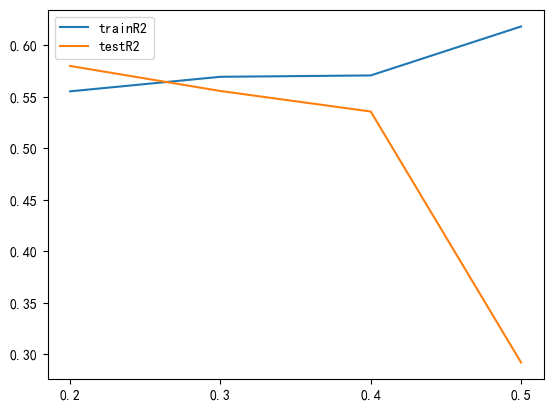

In [72]:
plt.plot(trainr2,label="trainR2")
plt.plot(testr2,label="testR2")
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5])
plt.legend();

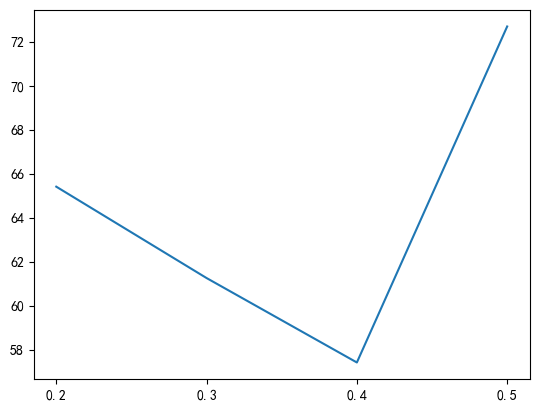

In [73]:
plt.plot(testRMSE)
plt.xticks(ticks=[0,1,2,3],labels=[0.2,0.3,0.4,0.5]);

In [74]:
testRMSE

[65.4079506968016, 61.25139090316122, 57.4101904498173, 72.69578370422477]

从结果的角度来看，在测试集上RMSE最低的训练集数量是0.4，从R2的表现来看，测试集比例为0.4时，训练集上R2表现出过拟合的倾向，但并不严重。但考虑到现在模型的核心评估指标是RMSE，因此R2稍有问题，但RMSE明显有优势时，我们优先考虑RMSE上的表现。

In [75]:
Xtrain, Xtest, Ytrain, Ytest = TTS(X,y,test_size=0.4,random_state=0)

注意索引操作。通常我们我们在分割完训练集与测试集后，需要将索引规范为range(0,x)系列，但是这次我们不恢复索引，而让索引跟随Xtrain，Xtest分割后的样子（理由稍后呈现）：

In [76]:
Ytrain = pd.DataFrame(Ytrain)
Ytest = pd.DataFrame(Ytest)

Ytrain.index = Xtrain.index
Ytest.index = Xtest.index

In [77]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
1914412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0
188838,26375.0,4200.0,0.0,0.0,0.0,0.0,32000.0,2250.0,0.0,0.0,...,8996.153846,0.0,1.536232,0.0,0,0,1,0,1,0
1879427,2063.0,1350.0,0.0,0.0,0.0,0.0,1531.0,675.0,0.0,0.0,...,184.307692,0.0,0.009662,0.0,0,0,1,0,1,0
1616849,56314.0,17460.0,0.0,0.0,0.0,0.0,76717.0,10850.0,0.0,0.0,...,12294.004918,0.0,1.026087,0.0,0,0,1,0,1,0
2046255,220125.0,3700.0,200000.0,0.0,200000.0,0.0,616375.0,2000.0,60000.0,0.0,...,299367.991676,0.0,2.260872,0.0,0,0,1,0,1,0


#### 5.3 异常值处理

在处理异常值时，我们发现所有的氪金玩家都被归类到了异常数据里，这与氪金玩家往往都是深入参与到游戏的玩家有很大的关系。由于玩家都被包括在异常数据中，我们不能对异常数据进行简单的删除，并且由于数据左偏严重，异常值数量众多（超出100w），删掉50%的数据也不可取。因此在这里，我们对异常值进行类似于盖帽的特殊处理。按照箱线图的规则进行异常检测，并对异常值中7日内无氪金的玩家进行中位数覆盖（如果效果不够好，可以试着使用0覆盖），对于7日内有氪金的玩家则不处理，尽量放大氪金玩家与非氪金玩家特征上的区别，为建模提供更好的保障。

注意：异常值处理必须在训练集测试集被分割的情况下进行，因为测试集上的异常值处理是必须依赖对训练集进行异常值处理所产生的中间变量的

In [78]:
import warnings #消除警告的代码
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [79]:
def AbnormalReplace(Xtrain,Xtest):
    #先对所有特征进行异常检测
    #对7日内付过费的用户，不处理
    #对7日内没付过费的用户，替换所有异常值为当前特征的中位数或者0
    
    Xtrain_ = Xtrain.copy()
    Xtest_ = Xtest.copy()
    for column in Xtrain_.columns:
        #提取当前要检测的列
        f_train = Xtrain_.loc[:,column]
        f_test = Xtest_.loc[:,column]

        #从训练集中计算出QL、QU、IQR、中位数
        QL = np.quantile(f_train,0.25)
        QU = np.quantile(f_train,0.75)
        IQR = QU - QL
        medium_ = f_train.median()
        
        #对训练集和测试集同时进行检测，得到True/False列表
        # 小于下界，大于上界
        errortrain = ((f_train < (QL - 1.5*IQR)).astype(int) + (f_train > (QU + 1.5*IQR)).astype(int)) != 0
        errortest = ((f_test < (QL - 1.5*IQR)).astype(int) + (f_test > (QU + 1.5*IQR)).astype(int)) != 0

        #将原矩阵中的异常值替换为中位数，主题排除7日付费用户
        #如果效果不够强烈，试试看替换为0
        Xtrain_.loc[((Xtrain_["付费金额"]==0).values & errortrain.values),column] = 0 #medium_
        Xtest_.loc[((Xtest_["付费金额"]==0).values & errortest.values),column] = 0 #medium_
        
    return Xtrain_, Xtest_

In [80]:
Xtrain["木头获取数量"].describe()

count    1.372804e+06
mean     4.597076e+05
std      5.253011e+06
min      0.000000e+00
25%      0.000000e+00
50%      4.193400e+04
75%      1.530618e+05
max      1.239962e+09
Name: 木头获取数量, dtype: float64

In [81]:
xtrain, xtest = AbnormalReplace(Xtrain,Xtest) #为了保留原始的Xtrain和Xtest，新生成的值我们写作小写

In [82]:
xtrain["木头获取数量"].describe() #查看处理数据确认数据变化

count    1.372804e+06
mean     2.534424e+05
std      5.186103e+06
min      0.000000e+00
25%      0.000000e+00
50%      1.000000e+04
75%      9.627125e+04
max      1.239962e+09
Name: 木头获取数量, dtype: float64

#### 5.4 归一化处理

加速运算，各个特征量纲统一 

使用线性回归的时候就可以查看系数来决定特征的重要性

In [83]:
from sklearn.preprocessing import MinMaxScaler 
# [0,1]最常使用的基本方式，x - x.min() / x.max() - x.min()

In [84]:
mm = MinMaxScaler(feature_range = (0,1)) #实例化，[0,1]

In [85]:
mm = mm.fit(xtrain) #训练 - 生成了训练集上的最小值和最大值

In [86]:
xtrain = mm.transform(xtrain) #使用训练集上的最小值和最大值对训练集/测试集同时进行归一化
xtest = mm.transform(xtest)

In [87]:
xtrain.min(),xtrain.max()

(0.0, 1.0)

In [88]:
xtest.min(),xtest.max()

(0.0, 1.3636363636363638)

#### 5.5 正态化处理 (选做)

```
from sklearn.preprocessing import PowerTransformer

pt = PowerTransformer(method='box-cox') #只能适用于正数

pt = pt.fit(xtrain)

xtrain = pt.transform(xtrain)
xtest = pt.transform(xtest)
```

理论上来说，正态化处理是有利于线性回归建模的，但是在多次尝试中，发现现在的数据在经过正态化处理会出现严重不稳定的情况，可能直接将RMSE拉高几十甚至上千，因此在本案例中不采取正态化处理。

## 6. 模型融合：处理极度偏态的数据带来的问题

在进行异常值处理时，我们发现所有的氪金用户都被包括在了异常用户中，这说明有大量未氪金的用户表现在游戏资源积累、游戏参与深度上的行为与氪金用户极为相似。同时，氪金用户与不氪金用户的用户组成都相对复杂。

在氪金用户中，有进入游戏1分钟就闭眼氪0.99的羊毛玩家，也有在游戏中7日都未氪、7日后不知为何突然磕了一点点的玩家。在不氪金用户中，有深度参与游戏但一分钱不氪肝帝，又有玩得很糟但一直不退游的玩家。因此在预测前其实就可以想象到，模型在用户辨别、金额预测上的效果恐怕不会太好。

在之前的特征处理中，我们已经对异常值进行过“盖帽”处理，并在特征中增加我们认为可以让氪金和非氪金用户区别变大的特征，但直接让单一模型对氪金用户的氪金数额进行预测是非常困难的。因此，我们可以使用2个模型进行融合预测，第一个模型是分类模型逻辑回归，我们让逻辑回归先对用户进行“氪与不氪”的预测，然后将逻辑回归认为会氪的用户放入线性回归，再让线性回归直接对“本来就很可能会氪金”的用户进行氪金金额预测。我们认为这样的方式经过适当调整后，应该能够提升模型表现。

- 创造逻辑回归使用的y

逻辑回归的标签：氪金(1)与不氪金(0)，1类远远少于0类

In [89]:
y2 = (y != 0).astype(int) #所有氪金用户转化为1，不氪金用户转化为0
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: 45日付费金额, dtype: int32

In [90]:
y2.value_counts() #45988 - 45天的时候有氪金金额的用户

45日付费金额
0    2242019
1      45988
Name: count, dtype: int64

In [91]:
1 - 45988/y2.shape[0]

0.9799004111438471

已经有 Xtrain,Xtest，线性回归用的Ytrain, Ytest，逻辑回归的y2

--> 

变成可以和Xtrain、Xtest相匹配的y2train, y2test

注意此时的y2的索引与分割之前的y一致，但我们将用来训练的xtrain的索引是经过分割之后的，因此我们需要按分割后的Xtrain和Xtest的索引来分割y2，这也是为什么之前我们没有将Xtrain，Xtest的索引修改为range(0,x)的原因。一旦修改，我们将失去分割后的组合与原始X,y之间的联系，也就无法构筑新标签y2的测试部分和训练部分了。

In [92]:
Xtrain.head()

字段解释,木头获取数量,木头消耗数量,石头获取数量,石头消耗数量,象牙获取数量,象牙消耗数量,肉获取数量,肉消耗数量,魔法获取数量,魔法消耗数量,...,玩家发育效率,氪金发育效率,玩家升级效率,氪金升级效率,潜力玩家,好战玩家,肝帝玩家,佛系玩家,菜鸡玩家,流失玩家
1914412,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0,0,1,0,1,0
188838,26375.0,4200.0,0.0,0.0,0.0,0.0,32000.0,2250.0,0.0,0.0,...,8996.153846,0.0,1.536232,0.0,0,0,1,0,1,0
1879427,2063.0,1350.0,0.0,0.0,0.0,0.0,1531.0,675.0,0.0,0.0,...,184.307692,0.0,0.009662,0.0,0,0,1,0,1,0
1616849,56314.0,17460.0,0.0,0.0,0.0,0.0,76717.0,10850.0,0.0,0.0,...,12294.004918,0.0,1.026087,0.0,0,0,1,0,1,0
2046255,220125.0,3700.0,200000.0,0.0,200000.0,0.0,616375.0,2000.0,60000.0,0.0,...,299367.991676,0.0,2.260872,0.0,0,0,1,0,1,0


In [93]:
Ytrain2 = y2[Xtrain.index] #以Xtrain,Xtest的分割方式来分割y2，这样y2就是与Ytrain相匹配的

In [94]:
Ytest2 = y2[Xtest.index]
Ytrain2.head() #注意索引与原来相对

1914412    0
188838     0
1879427    0
1616849    0
2046255    0
Name: 45日付费金额, dtype: int32

- 使用逻辑回归进行建模并使用ROC进行评估

In [95]:
from sklearn.linear_model import LogisticRegression as LogiR
from sklearn.metrics import roc_auc_score as ROC #ROC
from sklearn.metrics import recall_score as Recall #召回
from sklearn.metrics import precision_score as Precision #精确度

In [96]:
clf = LogiR(random_state=0) #逻辑回归的实例化

In [97]:
clf.fit(xtrain,Ytrain2) #训练，使用经过一切特征工程的特征矩阵xtrain

LogisticRegression(random_state=0)

In [98]:
clf.score(xtrain,Ytrain2) #逻辑回归在训练集上的准确率

0.9968094498559154

In [99]:
clf.score(xtest,Ytest2) #逻辑回归在测试集上的准确率

0.9968291187856683

In [100]:
#测试集的拟合情况
y2_proba = clf.predict_proba(xtest) #找出了逻辑回归在测试集上对每个样本预测的概率

In [101]:
y2_proba

array([[0.99489083, 0.00510917],
       [0.99816103, 0.00183897],
       [0.99823014, 0.00176986],
       ...,
       [0.99809905, 0.00190095],
       [0.99752905, 0.00247095],
       [0.99816337, 0.00183663]])

In [102]:
y2_proba[:,1] #提取出为1的概率

array([0.00510917, 0.00183897, 0.00176986, ..., 0.00190095, 0.00247095,
       0.00183663])

In [103]:
ROC(Ytest2,y2_proba[:,1]) #越接近1越好（越接近0越好），最糟糕的情况是接近0.5

0.9711818492842685

- RECALL：全部真实的1中，被预测正确的1所占的比例

![](http://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%208%20SVM%20%282%29/confusion%20matrix/Recall.PNG)

In [104]:
Recall(Ytest2,clf.predict(xtest))

0.8420766216804527

- PRECISION：全部被预测为1的值中，真实的1所占的比例

![](http://pictes.oss-cn-beijing.aliyuncs.com/%E5%BE%AE%E8%AF%BE%20-%20sklearn/week%208%20SVM%20%282%29/confusion%20matrix/Precision.PNG)

In [105]:
Precision(Ytest2,clf.predict(xtest))

1.0

逻辑回归的结果出乎意料地好，能够在样本不均衡如此严重的情况下达到0.98的ROC，证明该数据与逻辑回归非常适配。

- 调节阈值提升Recall

recall和precision结合起来看说明，所有被预测为1的值都预测正确了，但是还有部分被预测为0的值，实际上真正的值是1。在该recall和precision下，测试集捕捉出的1类（付费用户）数为：

In [106]:
(y2_proba[:,1] > 0.5).sum()

15474

实际付费用户数为：

In [107]:
(Ytest != 0).sum()

45日付费金额    18376
dtype: int64

也就是说，有许多氪金用户被逻辑回归分类到“不氪金”的范畴了，如果按照现在的结果建模，那RMSE的主要来源就是**没有被逻辑回归包括的氪金用户的氪金数额 + 被逻辑回归指向付费、受线性回归预测后的金额差异（状况A）**。

如果我们希望逻辑回归能够捕捉到所有真实氪金的用户，为此即便误伤一些没有氪金的用户，那我们就要努力提升Recall，此时RMSE的主要来源就是**被逻辑回归误认为是氪金用户的非氪用户在线性回归中的预测值 + 全部真实氪金用户经过线性回归预测后的金额差异（状况B）**。注意该状况下需要线性回归预测的值会更多。

为难的是，我们现在并不知道这两种状况中哪种会有整体更低的RMSE，但我们知道现状就是状况A，如果我们需要提升Recall的话就可以降低逻辑回归中用于分类的阈值。

在逻辑回归中，当预测出概率后，一般我们认为阈值是0.5，当概率大于0.5时样本的标签为1，当概率小于0.5时样本的标签为0。如果想要提升Recall，可以降低模型的阈值。然而，sklearn中的逻辑回归并不提供该功能，因此我们需要自己计算调整阈值后的Recall。来看下面的代码：

In [108]:
#找出模型之前预测的1类概率
prob = y2_proba[:,1]

In [109]:
#尝试更换阈值
(prob > 0.3).astype(int) #阈值为0.3下的预测标签

array([0, 0, 0, ..., 0, 0, 0])

In [110]:
#在0~0.5中循环20个阈值备选数，会发现阈值越低，recall越高
for tol in np.linspace(0,0.5,20):
    pred = (prob >= tol).astype(int)
    recall = Recall(Ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))

0.000 Recall:1.000
0.026 Recall:0.890
0.053 Recall:0.864
0.079 Recall:0.854
0.105 Recall:0.852
0.132 Recall:0.852
0.158 Recall:0.851
0.184 Recall:0.850
0.211 Recall:0.850
0.237 Recall:0.849
0.263 Recall:0.849
0.289 Recall:0.848
0.316 Recall:0.847
0.342 Recall:0.847
0.368 Recall:0.846
0.395 Recall:0.846
0.421 Recall:0.844
0.447 Recall:0.844
0.474 Recall:0.843
0.500 Recall:0.842


In [111]:
for tol in np.linspace(0,0.026,20): #在0~0.026之间再选择一个更小的阈值
    pred = (prob >= tol).astype(int)
    recall = Recall(Ytest2,pred)
    print("{:.3f} Recall:{:.3f}".format(tol,recall))

0.000 Recall:1.000
0.001 Recall:0.995
0.003 Recall:0.958
0.004 Recall:0.938
0.005 Recall:0.927
0.007 Recall:0.921
0.008 Recall:0.915
0.010 Recall:0.911
0.011 Recall:0.907
0.012 Recall:0.904
0.014 Recall:0.902
0.015 Recall:0.901
0.016 Recall:0.899
0.018 Recall:0.898
0.019 Recall:0.897
0.021 Recall:0.896
0.022 Recall:0.895
0.023 Recall:0.894
0.025 Recall:0.892
0.026 Recall:0.890


In [112]:
#预设阈值
#现状：0.5
#可能的让recall升高并且降低RMSE的值：尝试0.026
#可能让recall升高但或许会误伤太多0类导致RMSE升高的值：尝试0.014

tol_ = 0.02 #多次实验之后，确认了阈值0.02可能是一个比较合适的值

In [113]:
#在0.02阈值下，逻辑回归预测了测试集中的多少样本为1
(y2_proba[:,1] >= tol_).sum()

31451

In [114]:
#训练集中的多少样本被预测为1
(clf.predict_proba(xtrain)[:,1] >= tol_).sum()

47087

以上就是我们需要带入线性回归进行建模的数据量。

- 保留逻辑回归按阈值为0.02时的预测结果

In [115]:
#对于所有不氪金的样本而言，预测已经到此结束了 - 标签y为0
#测试集，千万别忘记将Xtest的索引导入
result = pd.DataFrame(y2_proba[:,1],index=Xtest.index)
result.columns = ["logi_proba"]
result["logi_y_pred"] = (result["logi_proba"] >= tol_).astype(int)

In [116]:
result.head()

,logi_proba,logi_y_pred
660869,0.005109,0
1002543,0.001839,0
2044898,0.001770,0
961802,0.001271,0
793236,0.004634,0


In [117]:
#训练集，同样索引需要导入
logi_train_result = pd.DataFrame(clf.predict_proba(xtrain)[:,1],index=Xtrain.index)
logi_train_result.columns = ["logi_train_proba"]
logi_train_result["logi_y_pred_train"] = (logi_train_result["logi_train_proba"] >= tol_).astype(int)

In [118]:
logi_train_result.head()

,logi_train_proba,logi_y_pred_train
1914412,0.001827,0
188838,0.001754,0
1879427,0.001506,0
1616849,0.001925,0
2046255,0.002151,0


- 选出应该放出线性回归中的训练集与测试集

In [119]:
#训练集：逻辑回归的预测标签为1的部分
xtrain_linear_reg = xtrain[logi_train_result["logi_y_pred_train"] == 1]
ytrain_linear_reg = Ytrain[logi_train_result["logi_y_pred_train"] == 1]

In [120]:
xtrain_linear_reg.shape #确认与训练集中被预测为1的样本数一致

(47087, 119)

In [121]:
#测试集
xtest_linear_reg = xtest[result["logi_y_pred"] == 1]
ytest_linear_reg = Ytest[result["logi_y_pred"] == 1]

In [122]:
xtest_linear_reg.shape

(31451, 119)

- 开始回归预测

In [123]:
def reg_predict(model):
    reg = model.fit(xtrain_linear_reg, ytrain_linear_reg) #训练
    y_linear_pred = reg.predict(xtest_linear_reg) #对测试集进行预测
    print("训练集R2:{:.3f}".format(reg.score(xtrain_linear_reg, ytrain_linear_reg)))
    print("测试集R2:{:.3f}".format(reg.score(xtest_linear_reg, ytest_linear_reg)))
    print("测试集RMSE:{:.3f}".format(np.sqrt(MSE(ytest_linear_reg,y_linear_pred))))
    return y_linear_pred #融合模型预测出的结果中的 - 回归部分

In [124]:
#线性回归
reg0 = LR()

In [125]:
y_linear_pred0 = reg_predict(reg0) #没有什么参数可以调整的

训练集R2:0.581
测试集R2:0.537
测试集RMSE:305.916


In [126]:
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.ensemble import GradientBoostingRegressor as GBR

In [127]:
reg1 = RFR(n_estimators=100,max_depth=2,max_features=20,random_state=1412)
reg2 = GBR(n_estimators=100,max_depth=2,max_features=20,random_state=1412)

In [128]:
y_linear_pred1 = reg_predict(reg1) #随机森林这个算法就是不太适合现在的数据

训练集R2:0.517
测试集R2:0.426
测试集RMSE:340.585


In [129]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.734
测试集R2:0.538
测试集RMSE:305.631


可以看到，随机森林不适合该数据，GBR与LR相近，但LR调参空间很小，可优化空间小，因此选择GBR进一步调优

### 7. 模型调优

时间原因不使用学习曲线、交叉验证、网格搜索等方法进行模型调优

模型处于过拟合状态

- 经验调参
    - 增大树的数量提升拟合能力，同时控制树的深度防止过拟合严重
    - 降低学习率
    - 特征数量 控制过拟合

In [130]:
reg2 = GBR(n_estimators = 490 # 首先考虑的是增大模型的树的数量，来提升整体拟合能力
           ,max_depth= 2 # 但又很容易过拟合，因此控制住树的深度
           ,learning_rate= 0.05 # 当n_estimators和max_depth调不出好结果时，有限考虑降低学习率，学习率对树模型的效果影响很大
           ,max_features = 50 # max_features的存在一开始主要是为了控制建模速度的，但是也可以控制过拟合，可以使用学习曲线找适合的阶段和位置
           ,min_samples_split = 25 # 如果模型仍然过拟合，可以试着增加min_samples_split，增大允许分叶子的样本数量，以此来减少树的拟合程度
           ,random_state= 1412)

In [131]:
y_linear_pred2 = reg_predict(reg2)

训练集R2:0.796
测试集R2:0.567
测试集RMSE:295.724


- 将线性回归与逻辑回归的预测值合并

In [132]:
result["reg_result"] = 0 #创建新列，全部为0

In [133]:
#将逻辑回归的预测标签为1的样本提出来，对所有这些样本的“reg_result”回归结果列填入回归的预测结果y_linear_pred
result.loc[result["logi_y_pred"] == 1,"reg_result"] = y_linear_pred2

In [134]:
result.head()

,logi_proba,logi_y_pred,reg_result
660869,0.005109,0,0.0
1002543,0.001839,0,0.0
2044898,0.001770,0,0.0
961802,0.001271,0,0.0
793236,0.004634,0,0.0


In [135]:
Ytest.head() #确认索引一致

,45日付费金额
660869,0.0
1002543,0.0
2044898,0.0
961802,0.0
793236,0.0


In [136]:
np.sqrt(MSE(Ytest,result["reg_result"]))

55.562407990988135

比赛分数排名

![](https://skojiangdoc.oss-cn-beijing.aliyuncs.com/micro_class/sklearncase/%E6%8E%92%E8%A1%8C%E6%A6%9C.PNG)

模型可以进一步优化

In [137]:
FeatureImportance = pd.concat([pd.DataFrame(Xtrain.columns),pd.DataFrame(reg2.feature_importances_)],axis=1)

In [138]:
FeatureImportance.sort_values(0,ascending=False) #特征重要性

,字段解释,0
104,付费金额,0.250347
105,付费次数,0.090604
23,通用加速使用数量,0.066140
28,训练加速获取数量,0.062818
4,象牙获取数量,0.057614
...,...,...
85,科研：据点二,0.000000
51,科研：巨兽驯兽师,0.000000
50,科研：守护者,0.000000
17,勇士伤兵恢复数量,0.000000


- **改进空间**
> 1. 使用聚合方式创造特征
> 2. 使用分箱处理连续型特征（对线性回归有异常好的效果）
> 3. 更换更强大的算法（如神经网络/LGBM）